# Chatbot

In [1]:
import pickle
import numpy as np

In [2]:
with open("train_qa.txt","rb") as f:
    train_data = pickle.load(f)

In [3]:
with open("test_qa.txt","rb") as f:
    test_data = pickle.load(f)

The reason for using pickle is not justified here. However, pickle is capable to convert byte-stream or binary files to python like lists or dictionaries more easily, we use pickles in this case

In [4]:
type(train_data)

list

In [5]:
print(f"The training data is {len(train_data)} long and the test data is {len(test_data)} long")

The training data is 10000 long and the test data is 1000 long


How is the data looking like?

In [6]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

So it looks like a tuple of length three and the first two elements are list and the last one is a string. The first item is a list telling short story and the second one asks a question on the short story and the third item which is a string tells the right answer for this string

In [7]:
all_data = test_data + train_data # because both of these variables are lists of all the individual items#

In [8]:
len(all_data)

11000

But there will be repeating elements and for that let us use a set

In [9]:
vocab = set()

In [10]:
for story, question , answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [11]:
vocab.add('no')
vocab.add('yes')

In [12]:
vocab_len = len(vocab) + 1

In [13]:
len(vocab)

37

In [14]:
max_story_len = max([len(data[0]) for data in all_data])

In [15]:
max_story_len

156

In [16]:
max_question_len = max([len(data[1]) for data in all_data])

Now we will understand the steps on how to vectorize the data and for that lets create function that can vectorize the data for us

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

2024-11-08 14:11:08.733028: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-08 14:11:08.745304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731071468.760192  273152 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731071468.764635  273152 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 14:11:08.779681: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [18]:
tokenizer = Tokenizer(filters=[])

In [19]:
tokenizer.fit_on_texts(vocab)

In [20]:
tokenizer.word_index

{'bedroom': 1,
 'travelled': 2,
 'took': 3,
 'office': 4,
 'grabbed': 5,
 'left': 6,
 'got': 7,
 'is': 8,
 'no': 9,
 'journeyed': 10,
 'the': 11,
 'mary': 12,
 'went': 13,
 'back': 14,
 'put': 15,
 'to': 16,
 'up': 17,
 'down': 18,
 'yes': 19,
 'kitchen': 20,
 'john': 21,
 '?': 22,
 'moved': 23,
 'discarded': 24,
 'sandra': 25,
 '.': 26,
 'garden': 27,
 'hallway': 28,
 'dropped': 29,
 'there': 30,
 'daniel': 31,
 'bathroom': 32,
 'football': 33,
 'picked': 34,
 'apple': 35,
 'in': 36,
 'milk': 37}

Now we need to tokenize each story, question and answer using a function

In [21]:
def vectorize_stories(data, word_index = tokenizer.word_index, max_story_len = max_story_len, max_question_len = max_question_len ):
    

    # stories
    X = []
    # questions
    Xq = []
    # Y correct answer (yes/no)
    Y = [] 

    for story, question, answer in data:

        # Story
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in question]

        y = np.zeros(len(word_index)+1)
        y[word_index[answer]] = 1

        X.append(x)
        Y.append(y)
        Xq.append(xq)

    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [22]:
inputs_train, questions_train, answers_train = vectorize_stories(train_data)

Let's see how the inputs_train variable looks like

In [23]:
inputs_train

array([[ 0,  0,  0, ..., 11,  1, 26],
       [ 0,  0,  0, ..., 11, 28, 26],
       [ 0,  0,  0, ..., 11, 32, 26],
       ...,
       [ 0,  0,  0, ..., 11,  1, 26],
       [ 0,  0,  0, ..., 37, 30, 26],
       [ 0,  0,  0, ..., 35, 30, 26]], dtype=int32)

In [24]:
inputs_test, questions_test, answers_test = vectorize_stories(test_data)

In [25]:
from tensorflow.keras.models import Sequential,Model

In [26]:
from tensorflow.keras.layers import Embedding

In [27]:
from tensorflow.keras.layers import Input,Activation,Dense,Permute,Dropout,add,dot,concatenate,LSTM

In [28]:
# shape max_story_len,batch_size
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [29]:
vocab_size = len(vocab) + 1

In [30]:
# input encoder m
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3)) # randomly turn few neurons off to avoid over-fitting

# OUTPUT
# (samples, story_maxlen, embeding_dim)

2024-11-08 14:12:25.587433: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-11-08 14:12:25.587465: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: PBRO-23-010-LX
2024-11-08 14:12:25.587473: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: PBRO-23-010-LX
2024-11-08 14:12:25.587581: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 535.183.1
2024-11-08 14:12:25.587600: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 535.183.1
2024-11-08 14:12:25.587607: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 535.183.1


In [31]:
# input encoder c
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3)) # randomly turn few neurons off to avoid over-fitting

# OUTPUT
# (samples, story_maxlen, max_question_len)

In [32]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,output_dim=64,input_length = max_question_len))
question_encoder.add(Dropout(0.3)) # randomly turn few neurons off to avoid over-fitting

/home/rampalli/anaconda3/envs/nlp/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [33]:
# ENCODED <-- ENCODER(INPUT)

input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [34]:
match = dot([input_encoded_m,question_encoded],axes = (2,2))
match = Activation('softmax')(match)


In [35]:
response = add([match,input_encoded_c])
response = Permute((2,1))(response)

In [36]:
answer = concatenate([response,question_encoded])

In [37]:
answer

<KerasTensor shape=(None, 6, 220), dtype=float32, sparse=False, name=keras_tensor_18>

In [38]:
answer = LSTM(32)(answer)

In [39]:
answer = Dropout(0.5)(answer)

In [40]:
answer = Dense(vocab_size)(answer)

In [41]:
answer = Activation("softmax")(answer)

In [42]:
model = Model([input_sequence,question],answer)

In [43]:
model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy',metrics=['accuracy'])

In [44]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 156)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 156, 64)   │      2,432 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 6, 64)     │      2,432 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 156, 6)    │          0 │ sequential[0][0], │
│                     │                   │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 156, 6)    │          0 │ dot[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 156, 6)    │        228 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 156, 6)    │          0 │ activation[0][0], │
│                     │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 6, 156)    │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 6, 220)    │          0 │ permute[0][0],    │
│ (Concatenate)       │                   │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 32)        │     32,384 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 38)        │      1,254 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 38)        │          0 │ dense[0][0]       │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,730 (151.29 KB)

 Trainable params: 38,730 (151.29 KB)

 Non-trainable params: 0 (0.00 B)

Going forward we will train the network, plot out the training history, evaluate on test set and create our own stories and questions

In [45]:
history = model.fit([inputs_train,questions_train],answers_train,batch_size=32,epochs=100,validation_data=([inputs_test,questions_test],answers_test))

Epoch 1/100


/home/rampalli/anaconda3/envs/nlp/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4632 - loss: 1.2721 - val_accuracy: 0.4940 - val_loss: 0.6949
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5076 - loss: 0.7167 - val_accuracy: 0.4970 - val_loss: 0.6984
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5089 - loss: 0.6986 - val_accuracy: 0.4970 - val_loss: 0.6937
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5040 - loss: 0.6961 - val_accuracy: 0.4990 - val_loss: 0.6932
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4995 - loss: 0.6958 - val_accuracy: 0.4960 - val_loss: 0.6932
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5030 - loss: 0.6953 - val_accuracy: 0.4970 - val_loss: 0.6942
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4930 - loss: 0.6957 - val_accuracy: 0.5060 - val_loss: 0.6932
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4909 - loss: 0.6959 - val_accuracy: 0.4970

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


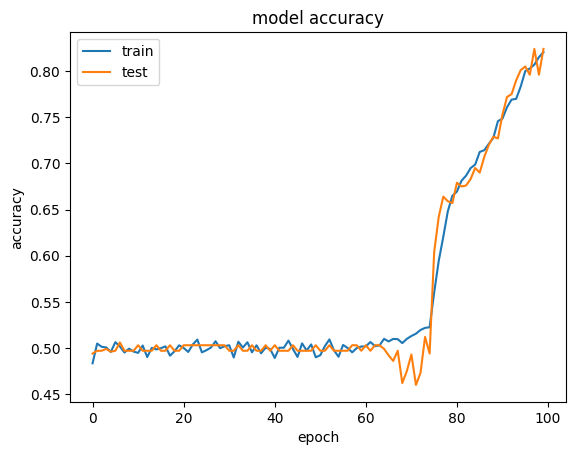

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluating on the test set

In [51]:
pred_results = model.predict(([inputs_test, questions_test]))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [52]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [53]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [54]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [55]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [56]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.98788226
